In [32]:
import os, sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent))

from preprocess import VN30, preprocess_v1, preprocess_v3
from sklearn.preprocessing import StandardScaler

# Bước 1: Tiền xử lý dữ liệu

In [33]:
_ = preprocess_v1('ACB', lag=30, val=0.2, verbose=True)

=== Preprocessing ACB ===
Train shape: (970, 167), Val shape: (243, 167), Test shape: (296, 167)


In [34]:
_ = preprocess_v3('ACB', lag=30, val=0.2, verbose=True)

Train shape: (972, 120), (972, 4)
Valid shape: (243, 120), (243, 4)


# Bước 2: Huấn luyện mô hình

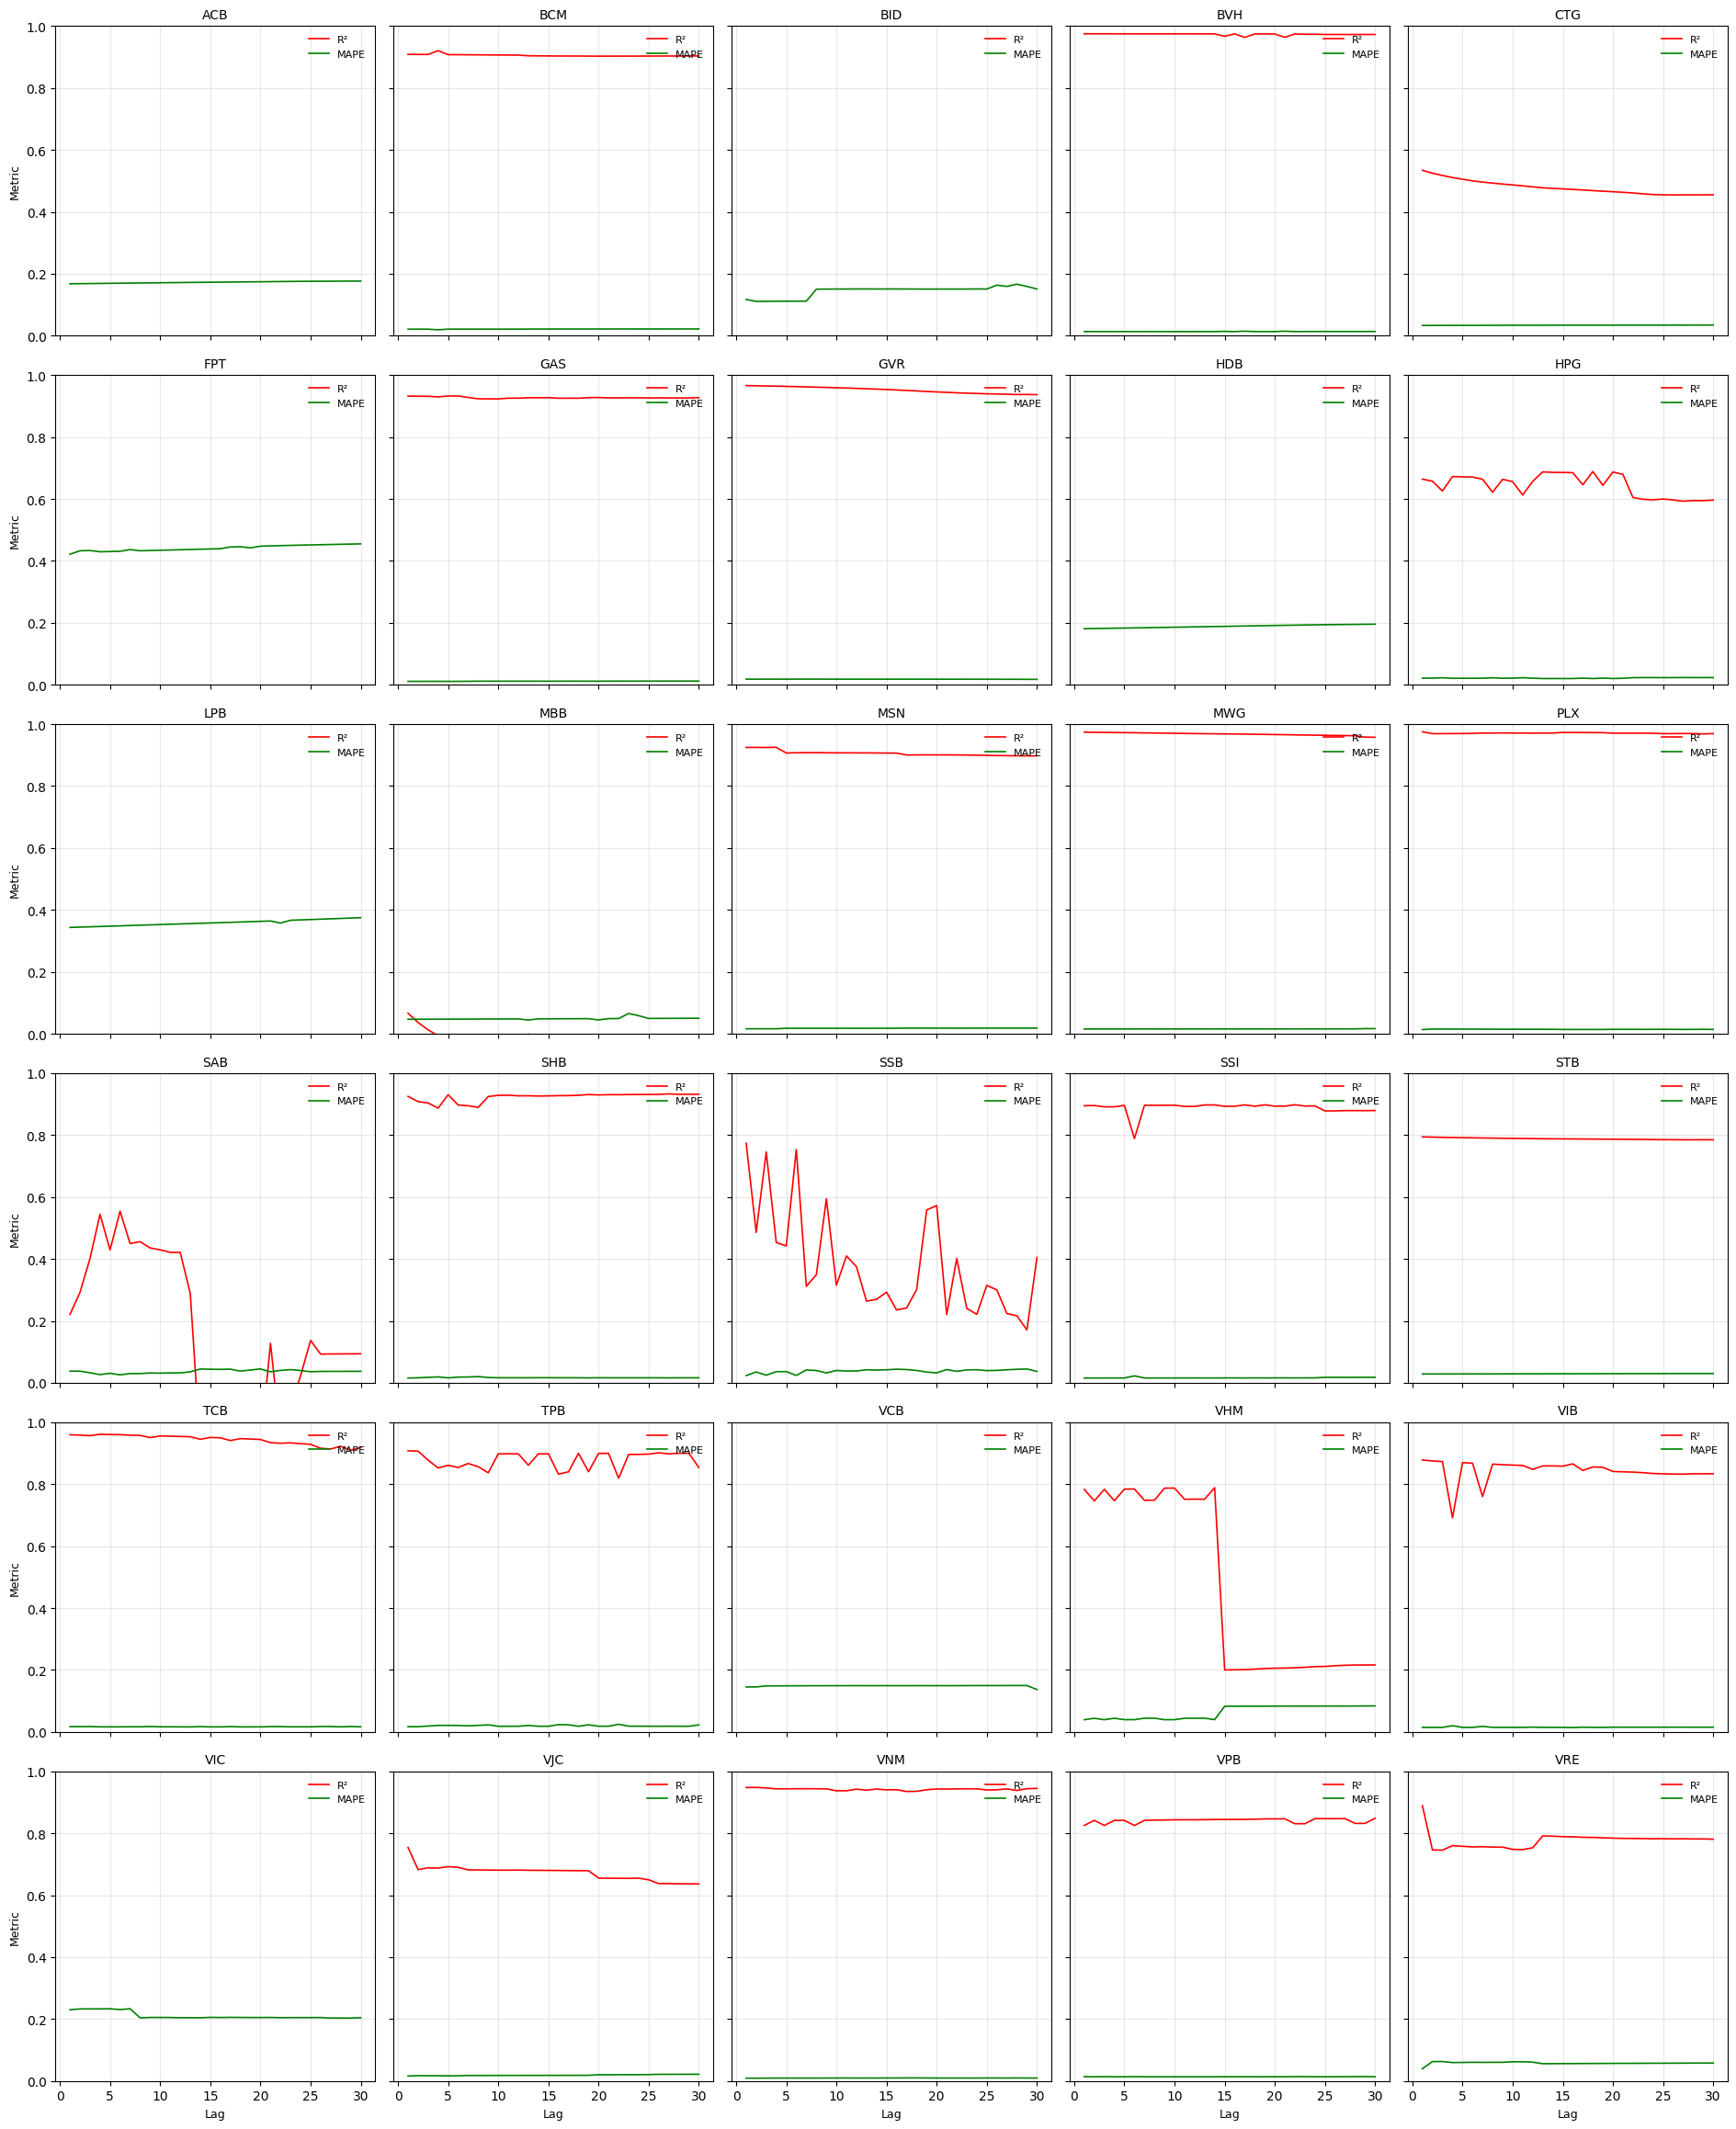

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Danh sách lag và độ sâu cây để thử
lags = list(range(1, 31))
list_depth_dt = [i * 5 for i in range(1, 7)]

fig, axes = plt.subplots(6, 5, figsize=(20, 24), sharex=True, sharey=True)

for idx, symbol in enumerate(VN30):
    r2_list = []
    mape_list = []

    # Tính R² và MAPE cho mỗi lag
    for lag in lags:
        data = preprocess_v1(
            symbol,
            lag=lag,
            val=0.2,
            calendar_feature=False,
            rolling_feature=False,
            technical_feature=False,
            nonlinear_feature=False,
            autocorr_feature=False,
            trend_feature=False,
        )
        X_train, Y_train = data["train"]
        X_val, Y_val = data["val"]
        X_test, Y_test = data["test"]
        target_scaler = data["scaler"]["target"]

        # Chọn max_depth tốt nhất trên tập validation
        best_r2 = -np.inf
        best_depth = None
        for depth in list_depth_dt:
            m = DecisionTreeRegressor(max_depth=depth, random_state=42)
            m.fit(X_train, Y_train)
            val = r2_score(Y_val, m.predict(X_val))
            if val > best_r2:
                best_r2, best_depth = val, depth

        # Huấn luyện lại và đánh giá trên test
        final = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
        final.fit(X_train, Y_train)
        pred_scaled = final.predict(X_test)

        # Unscale
        Y_pred = target_scaler.inverse_transform(pred_scaled)
        Y_true = target_scaler.inverse_transform(Y_test)

        # Tính metric
        r2_list.append(r2_score(Y_true, Y_pred))
        mape_list.append(mean_absolute_percentage_error(Y_true, Y_pred))

    # Vẽ lên subplot tương ứng
    row, col = divmod(idx, 5)
    ax = axes[row, col]

    ax.plot(lags, r2_list,
            linestyle='-', linewidth=1.2,
            color='red', label='R²')
    ax.plot(lags, mape_list,
            linestyle='-', linewidth=1.2,
            color='green', label='MAPE')

    ax.set_title(symbol, fontsize=10)
    ax.set_ylim(0, 1)

    # Chỉ đánh nhãn ở các trục ngoài cùng
    if row == 5:
        ax.set_xlabel('Lag', fontsize=9)
    if col == 0:
        ax.set_ylabel('Metric', fontsize=9)

    ax.legend(loc='upper right', fontsize=8, frameon=False)
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()

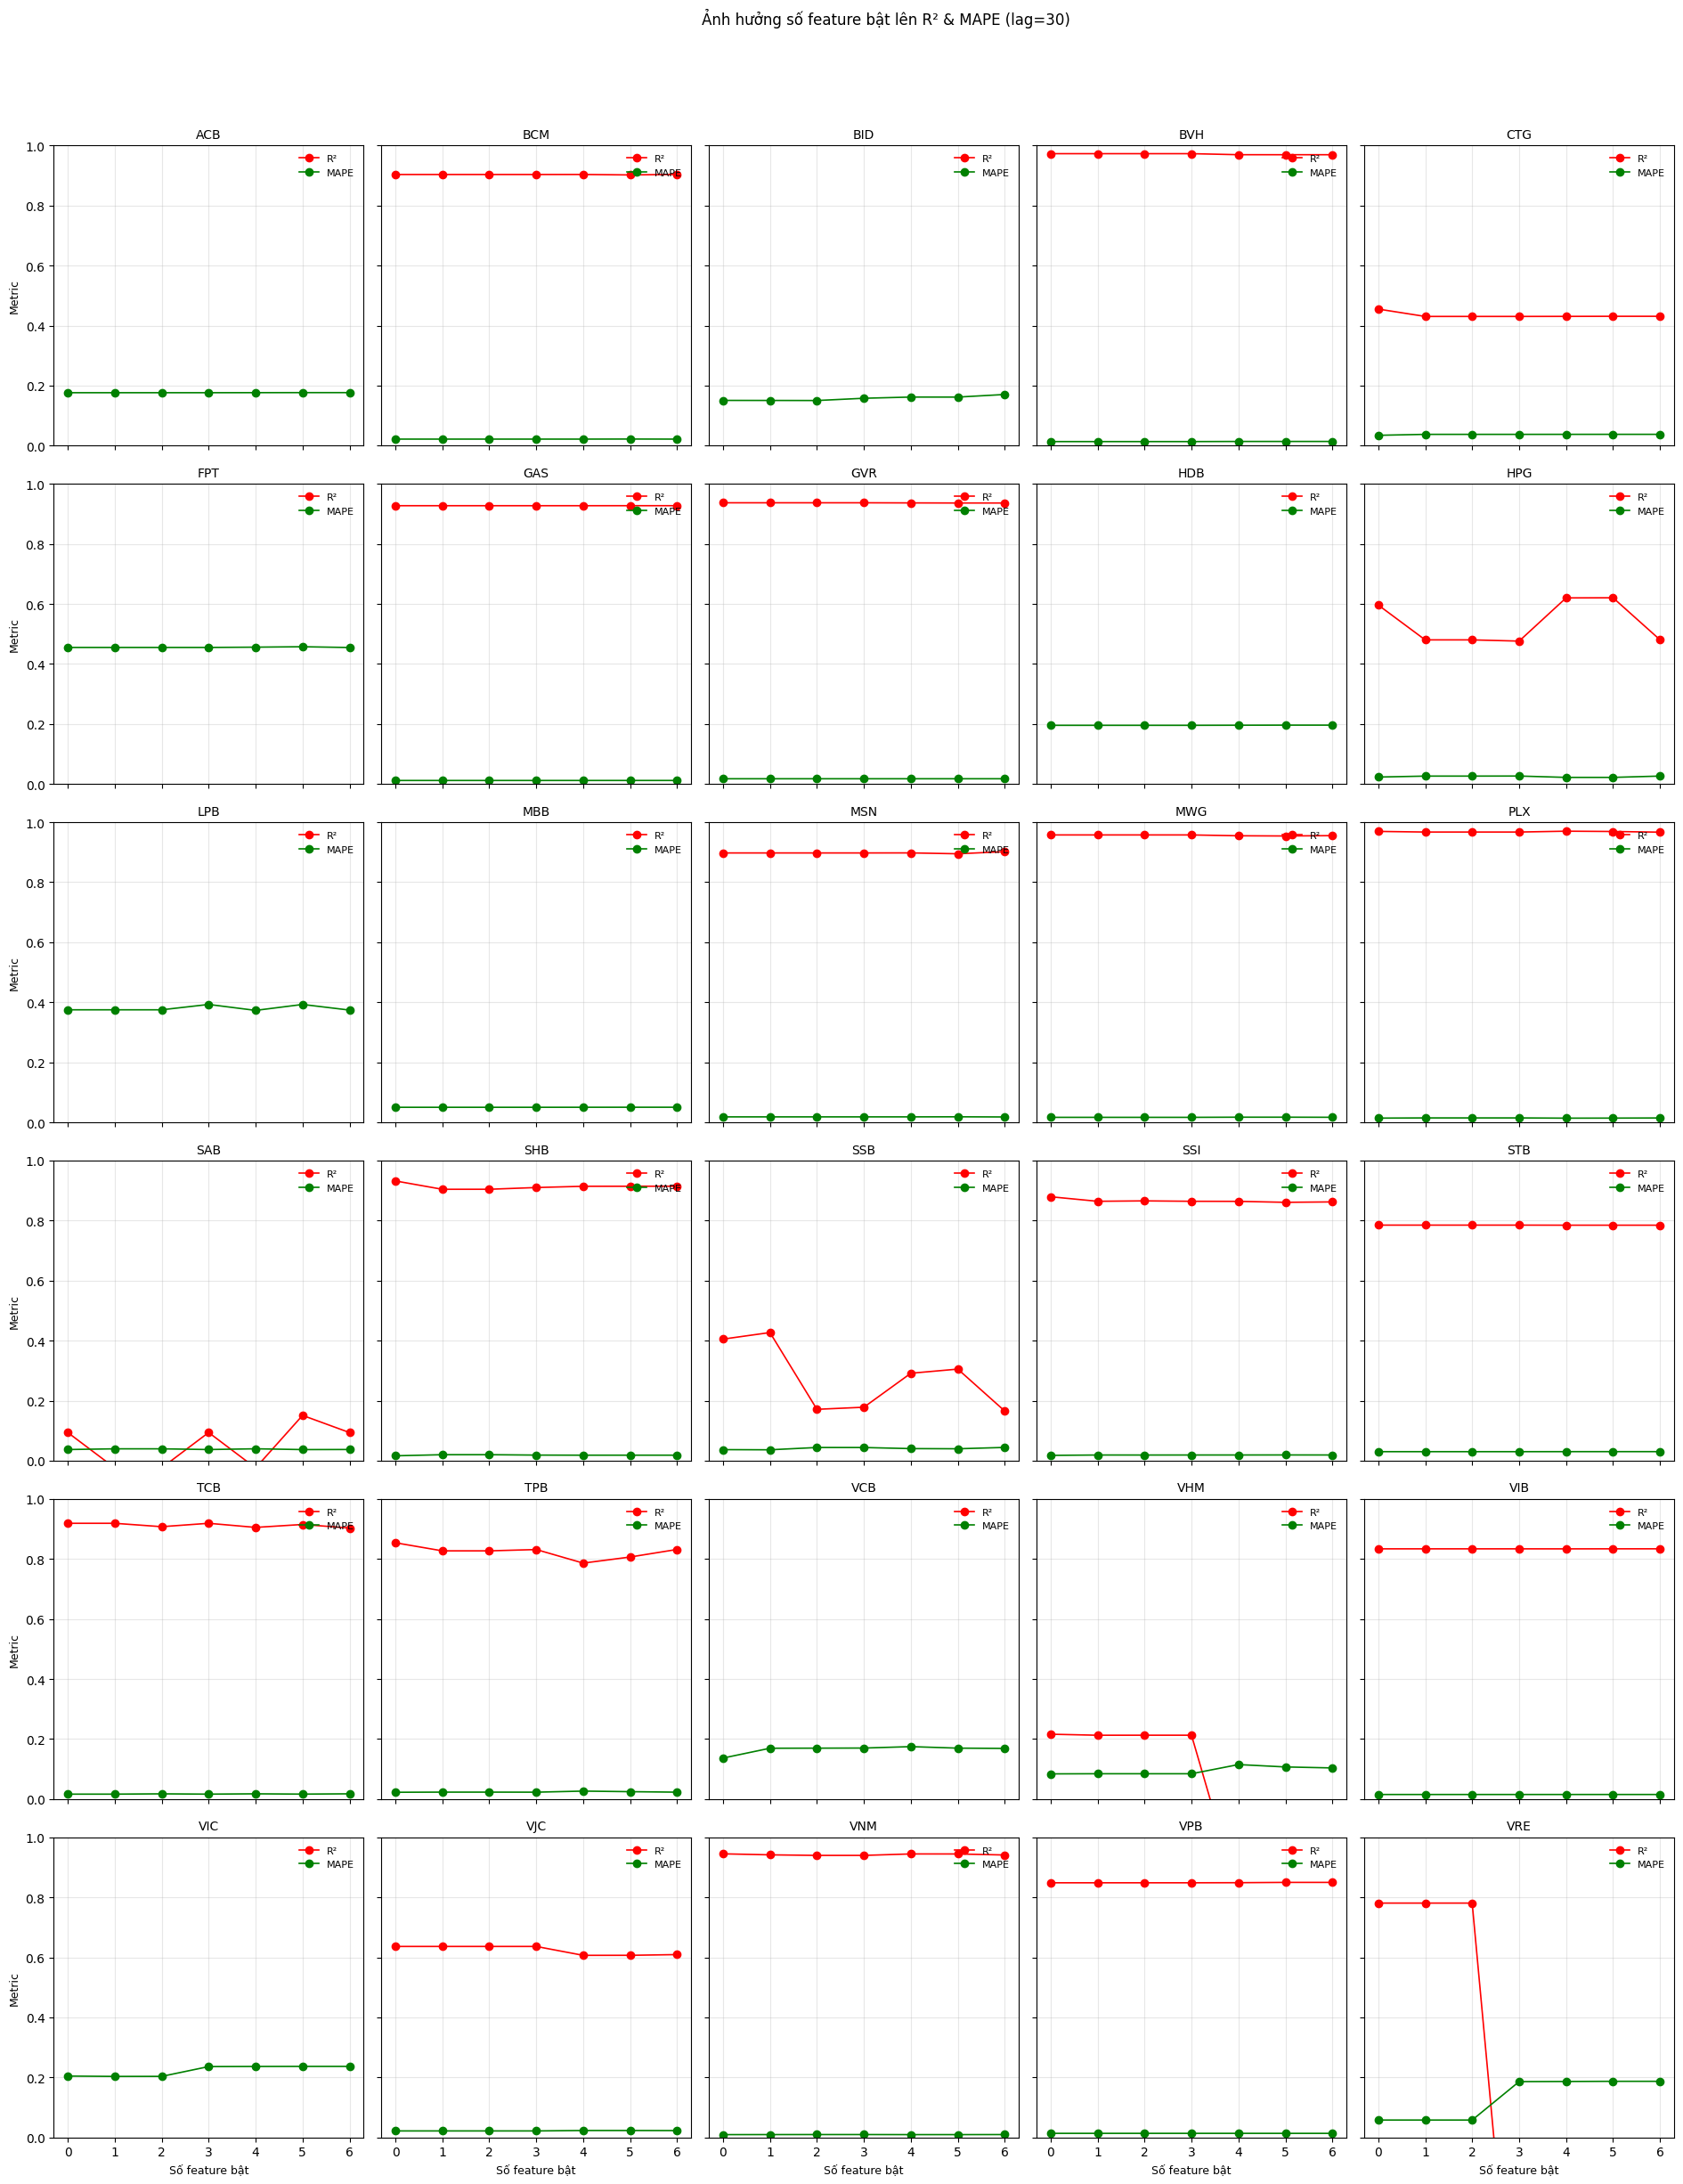

Đã lưu kết quả R² vào decision-tree.csv


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

feature_names = [
    "calendar_feature",
    "rolling_feature",
    "technical_feature",
    "nonlinear_feature",
    "autocorr_feature",
    "trend_feature",
]

configs = [{name:(i<k) for i,name in enumerate(feature_names)} 
           for k in range(len(feature_names)+1)]

depths = [i*5 for i in range(1,7)]  

r2_matrix   = []  
mape_matrix = []

for cfg in configs:
    r2_row, mape_row = [], []
    for symbol in VN30:
        data = preprocess_v1(
            symbol,
            lag=30,
            val=0.2,
            **cfg
        )
        X_tr, Y_tr = data["train"]
        X_val, Y_val = data["val"]
        X_te, Y_te   = data["test"]
        scaler_t     = data["scaler"]["target"]

        # chọn best max_depth trên validation
        best_r2, best_d = -np.inf, None
        for d in depths:
            m = DecisionTreeRegressor(max_depth=d, random_state=42)
            m.fit(X_tr, Y_tr)
            r2_val = r2_score(Y_val, m.predict(X_val))
            if r2_val > best_r2:
                best_r2, best_d = r2_val, d

        # đánh giá trên test
        m_final = DecisionTreeRegressor(max_depth=best_d, random_state=42)
        m_final.fit(X_tr, Y_tr)
        pred_scaled = m_final.predict(X_te)
        Y_pred = scaler_t.inverse_transform(pred_scaled)
        Y_true = scaler_t.inverse_transform(Y_te)

        r2_row.append(r2_score(Y_true, Y_pred))
        mape_row.append(mean_absolute_percentage_error(Y_true, Y_pred))

    r2_matrix.append(r2_row)
    mape_matrix.append(mape_row)

n_cols = 5
n_rows = int(np.ceil(len(VN30)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,4*n_rows),
                         sharex=True, sharey=True)

for idx, symbol in enumerate(VN30):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows>1 else axes[col]

    x         = list(range(len(configs)))  
    r2_list   = [r2_matrix[k][idx]   for k in x]
    mape_list = [mape_matrix[k][idx] for k in x]

    ax.plot(x, r2_list,   marker='o', linestyle='-', linewidth=1.2,
            color='red',   label='R²')
    ax.plot(x, mape_list, marker='o', linestyle='-', linewidth=1.2,
            color='green', label='MAPE')

    ax.set_title(symbol, fontsize=10)
    ax.set_ylim(0,1)
    if row == n_rows-1:
        ax.set_xlabel("Số feature bật", fontsize=9)
    if col == 0:
        ax.set_ylabel("Metric", fontsize=9)
    ax.legend(loc='upper right', fontsize=8, frameon=False)
    ax.grid(alpha=0.3)

total = n_rows*n_cols
for j in range(len(VN30), total):
    r, c = divmod(j, n_cols)
    ax = axes[r, c] if n_rows>1 else axes[c]
    ax.axis('off')

plt.tight_layout(rect=[0,0,0.95,0.97])
plt.suptitle("Ảnh hưởng số feature bật lên R² & MAPE (lag=30)", y=1.02)
plt.show()

out_file = "decision-tree.csv"
with open(out_file, "w", encoding="utf-8", buffering=1) as writer:
    writer.write("sep=,\n")
    writer.write("[R-squared] Flags," + ",".join(VN30) + "\n")
    for i, row in enumerate(r2_matrix):
        vals = ",".join(f"{v:.4f}" for v in row)
        writer.write(f"{i},{vals}\n")

print(f"Đã lưu kết quả R² vào {out_file}")


# Bước 3: Đánh giá mô hình

In [ ]:
list_depth_dt = [i * 5 for i in range(1, 7)]

for idx, symbol in enumerate(VN30):
    r2_list = []
    mape_list = []

    data = preprocess_v1(
        symbol,
        lag=30,
        val=0.2,
        calendar_feature=False,
        rolling_feature=False,
        technical_feature=False,
        nonlinear_feature=False,
        autocorr_feature=False,
        trend_feature=False,
    )
    X_train, Y_train = data["train"]
    X_val, Y_val = data["val"]
    X_test, Y_test = data["test"]
    target_scaler = data["scaler"]["target"]

    # Chọn max_depth tốt nhất trên tập validation
    best_r2 = -np.inf
    best_depth = None
    for depth in list_depth_dt:
        m = DecisionTreeRegressor(max_depth=depth, random_state=42)
        m.fit(X_train, Y_train)
        val = r2_score(Y_val, m.predict(X_val))
        if val > best_r2:
            best_r2, best_depth = val, depth

    # Huấn luyện lại và đánh giá trên test
    final = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
    final.fit(X_train, Y_train)
    pred_scaled = final.predict(X_test)

    # Unscale
    Y_pred = target_scaler.inverse_transform(pred_scaled)
    Y_true = target_scaler.inverse_transform(Y_test)

    # Tính metric
    r2_list.append(r2_score(Y_true, Y_pred))
    mape_list.append(mean_absolute_percentage_error(Y_true, Y_pred))
    # Lưu kết quả vào file
    out_file = "decision-tree-1.csv"
    with open(out_file, "a", encoding="utf-8", buffering=1) as writer:
        if symbol == VN30[0]:
            writer.write("Symbol,Best max_depth,R²,MAPE\n")
        writer.write(f"{symbol},{best_depth},{r2_list[0]:.4f},{mape_list[0]:.4f}\n")

In [39]:
list_depth_dt = [i * 5 for i in range(1, 7)]
TARGETS = ['open', 'high', 'low', 'close']

for idx, symbol in enumerate(VN30):
    r2_list = []
    mape_list = []

    data = preprocess_v3(
        symbol,
        lag=30,
        val=0.2
    )
    X_train, Y_train = data["train"]
    X_val, Y_val = data["val"]
    X_test, Y_test = data["test"]
    scaler = data["scaler"]

    # Chọn max_depth tốt nhất trên tập validation
    best_r2 = -np.inf
    best_depth = None
    for depth in list_depth_dt:
        m = DecisionTreeRegressor(max_depth=depth, random_state=42)
        m.fit(X_train, Y_train)
        val = r2_score(Y_val, m.predict(X_val))
        if val > best_r2:
            best_r2, best_depth = val, depth

    # Huấn luyện lại và đánh giá trên test
    final = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
    final.fit(X_train, Y_train)

    y_pred = final.predict(X_test)
    n_dim = len(TARGETS)
    X_win = X_test.reshape(-1, 30, n_dim)        # (N, lag, n_dim)
    last_scaled = X_win[:, -1, : ]                 # (N, n_dim)
    next_scaled = last_scaled + y_pred   # (N, n_dim)
    Y_true = last_scaled + Y_test
    
    # Unscale
    Y_pred = scaler.inverse_transform(next_scaled)
    Y_true = scaler.inverse_transform(Y_true)

    # Tính metric
    r2_list.append(r2_score(Y_true, Y_pred))
    mape_list.append(mean_absolute_percentage_error(Y_true, Y_pred))

    # in ra kết quả
    print(f"Symbol: {symbol}")
    print(f"Best max_depth: {best_depth}")
    print(f"R²: {r2_list[0]:.4f}")
    print(f"MAPE: {mape_list[0]:.4f}")

    # Lưu kết quả vào file
    out_file = "decision-tree-3.csv"
    with open(out_file, "a", encoding="utf-8", buffering=1) as writer:
        if symbol == VN30[0]: # Chỉ viết header cho record đầu tiên
            writer.write("Symbol,Best max_depth,R²,MAPE\n")
        writer.write(f"{symbol},{best_depth},{r2_list[0]:.4f},{mape_list[0]:.4f}\n")
    
    

Symbol: ACB
Best max_depth: 5
R²: 0.8153
MAPE: 0.0147
Symbol: BCM
Best max_depth: 5
R²: 0.9360
MAPE: 0.0166
Symbol: BID
Best max_depth: 5
R²: 0.9009
MAPE: 0.0111
Symbol: BVH
Best max_depth: 5
R²: 0.9713
MAPE: 0.0123
Symbol: CTG
Best max_depth: 5
R²: 0.8966
MAPE: 0.0200
Symbol: FPT
Best max_depth: 10
R²: 0.9750
MAPE: 0.0164
Symbol: GAS
Best max_depth: 5
R²: 0.9426
MAPE: 0.0099
Symbol: GVR
Best max_depth: 10
R²: 0.8964
MAPE: 0.0213
Symbol: HDB
Best max_depth: 5
R²: 0.7728
MAPE: 0.0374
Symbol: HPG
Best max_depth: 5
R²: 0.8928
MAPE: 0.0107
Symbol: LPB
Best max_depth: 5
R²: 0.9907
MAPE: 0.0185
Symbol: MBB
Best max_depth: 5
R²: 0.8390
MAPE: 0.0206
Symbol: MSN
Best max_depth: 5
R²: 0.9428
MAPE: 0.0128
Symbol: MWG
Best max_depth: 10
R²: 0.9631
MAPE: 0.0146
Symbol: PLX
Best max_depth: 10
R²: 0.9728
MAPE: 0.0124
Symbol: SAB
Best max_depth: 5
R²: -0.2805
MAPE: 0.0394
Symbol: SHB
Best max_depth: 10
R²: 0.9597
MAPE: 0.0097
Symbol: SSB
Best max_depth: 5
R²: 0.8142
MAPE: 0.0174
Symbol: SSI
Best max_d

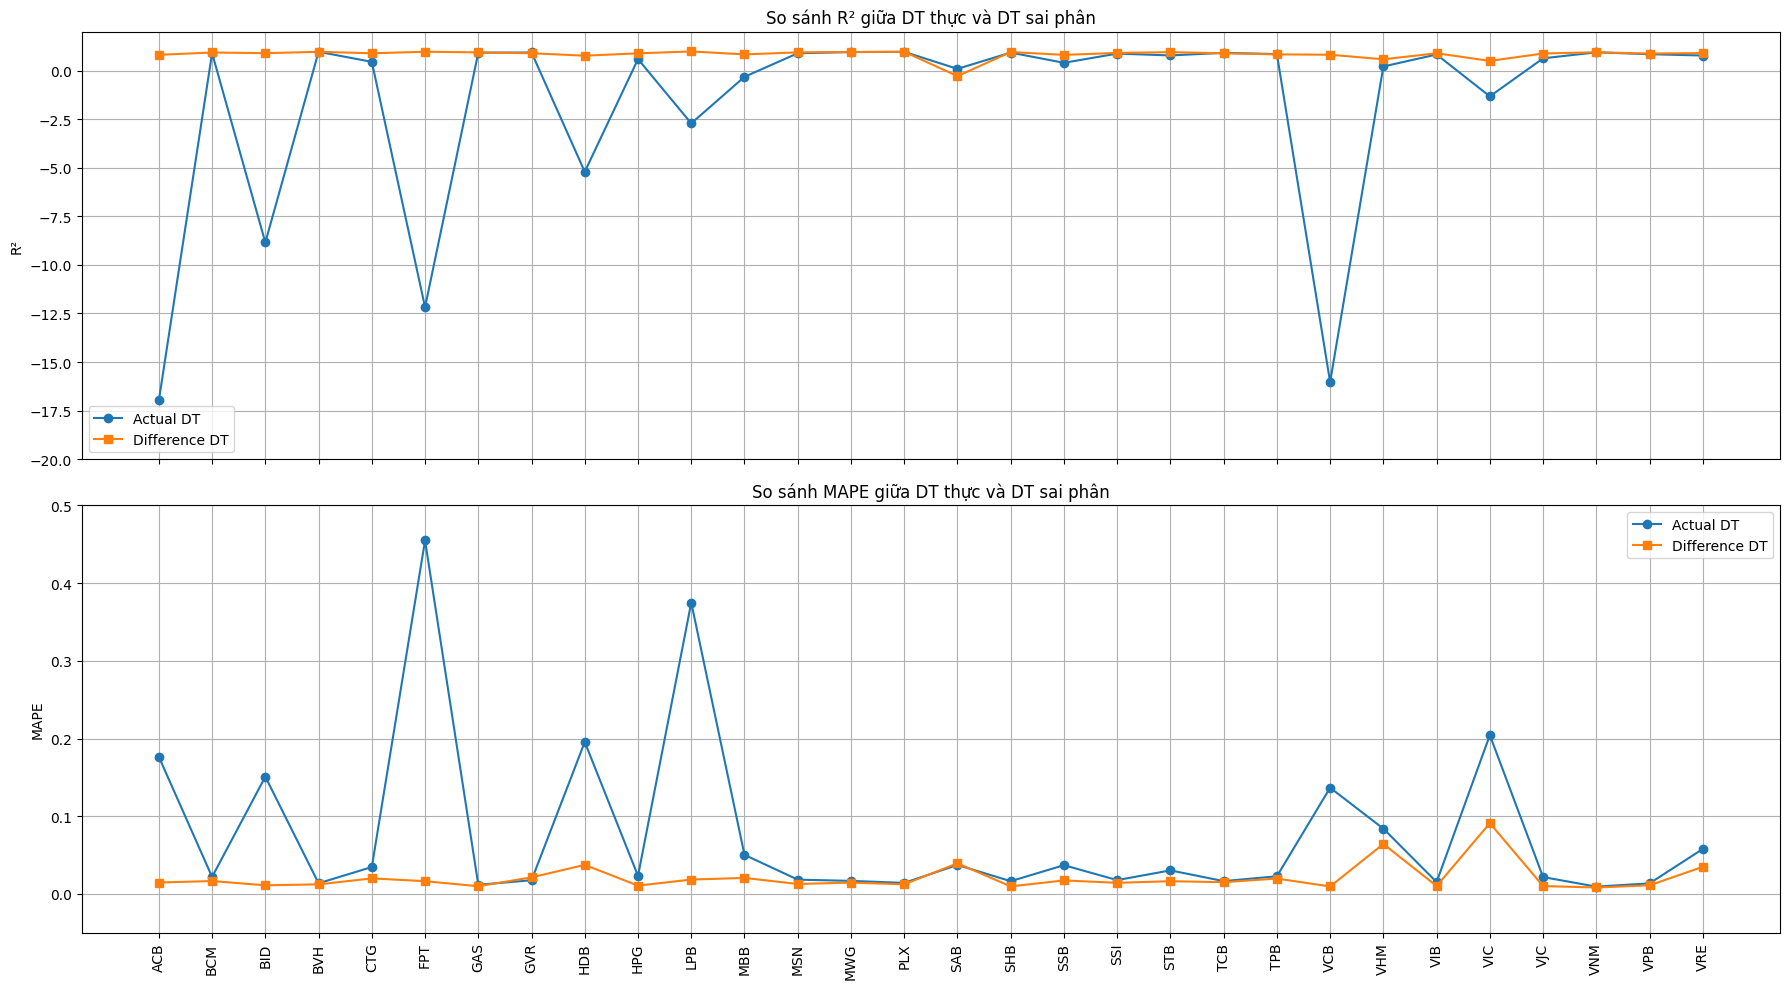

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data
df1 = pd.read_csv("decision-tree-1.csv")
df3 = pd.read_csv("decision-tree-3.csv")

# Remove duplicate rows if any
df1 = df1.drop_duplicates()
df3 = df3.drop_duplicates()

# Sort by Symbol to align both dataframes
df1 = df1.sort_values("Symbol").reset_index(drop=True)
df3 = df3.sort_values("Symbol").reset_index(drop=True)

symbols = df1["Symbol"]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Plot R² comparison
axes[0].plot(symbols, df1["R²"], marker='o', label="Actual DT")
axes[0].plot(symbols, df3["R²"], marker='s', label="Difference DT")
axes[0].set_ylabel("R²")
axes[0].set_ylim([-20, 2])
axes[0].set_title("So sánh R² giữa DT thực và DT sai phân")
axes[0].legend()
axes[0].grid(True)

# Plot MAPE comparison
axes[1].plot(symbols, df1["MAPE"], marker='o', label="Actual DT")
axes[1].plot(symbols, df3["MAPE"], marker='s', label="Difference DT")
axes[1].set_ylabel("MAPE")
axes[1].set_ylim([-0.05, 0.5])
axes[1].set_title("So sánh MAPE giữa DT thực và DT sai phân")
axes[1].set_xticks(range(len(symbols)))
axes[1].set_xticklabels(symbols, rotation=90)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
